In [1]:
%load_ext autoreload
%autoreload 2

# Analysis 1
This analysis was edited from the *opynfield* tutorial. Here, we are comparing two groups of Canton-S flies. We expect there to be no differences between the two groups.

## 1. Import the package and needed functions / classes

In [2]:
from opynfield.config.user_input import UserInput
from opynfield.config.defaults_settings import Defaults
from opynfield.config.cov_asymptote import CoverageAsymptote
from opynfield.config.model_settings import set_up_fits
from opynfield.config.plot_settings import PlotSettings
from opynfield.readin.run_all import run_all_track_types
from opynfield.calculate_measures.calculate_measures import tracks_to_measures
from opynfield.summarize_measures.summarize_individuals import individual_measures_to_dfs
from opynfield.summarize_measures.summarize_groups import all_group_averages
from opynfield.fit_models.fit_individual_models import fit_all, find_fit_bounds, re_fit_all
from opynfield.fit_models.fit_group_models import group_fit_all
from opynfield.stat_test.stat_test import format_params, format_group_params, run_tests
from opynfield.plotting.plot_individuals import plot_all_individuals, plot_traces
from opynfield.plotting.plot_solo_groups import plot_all_solo_groups
from opynfield.plotting.plot_solo_groups_with_individuals import plot_components_of_solo_groups
from opynfield.plotting.plot_group_comparisons import plot_all_group_comparisons
from opynfield.readin.summary_file import summary_file

from dataclasses import dataclass
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

## 2. Define the settings to use

### 2a. Set up your user inputs
In this dataset we have two groups, both recorded using Buridan's tracker, so our ``groups_and_types`` attribute of this ``UserInput`` dataclass will be ``{'CS1': ['Buridian Tracker'], 'CS2': ['Buridian Tracker']}``.

These group names have no special characters, so we could provide their names as-is to the ``groups_to_paths`` attribute (as ``{'CS1': 'CS1', 'CS2':'CS2'}``), but we could also provide an abbreviation or different display name, like ``{'CS1': 'CantonS_1', 'CS1': 'CantonS_2'}``.

We also need to provide ``arena_radius_cm`` with the radius of the arena that the tracks were recorded in. In this case, 4.2cm.

Next, the ``sample_freq``, or sampling frequency with which the tracks were recorded is 30Hz.

Then, we define the ``edge_dist_cm``, which is how far in from the boundary of the arena we should consider the 'edge region'. In this case, we will use 1cm.

Next, the ``time_bin_size``, or how many seconds pass between analysis point, we will set to 1s. Since our ``sample_freq`` was 30Hz, this means 30 samples will be aggregated together for each analysis point.

Then we define the ``inactivity_threshold``. Any movements smaller than this value will be ignored and attributed to body wobble. We will set this to 0.001cm.

Next we set the ``verbose`` setting. This indicates whether we want to display progress updates as the analysis runs. We will set this to True.

The final required ``UserInput`` setting is ``result_path``, which indicates where we would like the results to be saved. You will need to change this argument to a path on your computer.

In [3]:
user_settings = UserInput(groups_and_types = {"CS1": ["Buridian Tracker"], "CS2": ["Buridian Tracker"]},
                          groups_to_paths = {"CS1": "CantonS_1", "CS2": "CantonS_2"},
                          arena_radius_cm = 4.2,
                          sample_freq = 30,
                          edge_dist_cm = 1,
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis1/ExpectedResultsAnalysis1')

### 2b. Prep the results directory
Once you run the ``prep_directory()`` method, you should see the 'ExpectedResults' folder appear at the specified path.

In [4]:
user_settings.prep_directory()

### 2c. Set up the default settings
We don't need to change any of the deault settings for this analysis, but we can edit the ``time_averaged_measures`` and ``coverage_averaged_measures`` attributes to only calculate the models for the specific versions of the motion probabilities of coverage that we want to.

In [5]:
default_settings = Defaults()

In [6]:
default_settings.time_averaged_measures = ['activity', 'coverage', 'percent_coverage',
                                            'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                            'p_zero_plus_given_zero', 'p_zero_zero_given_zero']
default_settings.coverage_averaged_measures = ['activity',
                                                'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                                'p_zero_plus_given_zero', 'p_zero_zero_given_zero']

### 2d. Set up the coverage asymptote settings
We don't need to change any of the coverage asymptote settings for this analysis.

In [7]:
asymptote_settings = CoverageAsymptote()

### 2e. Set up the model settings
The easiest way to provide model settings (``ModelSpecification`` instances) for each valid pair of measures is to run the ``set_up_fits`` function.

It automatically pairs each possible x-axis (time, coverage, pica, pgca, and percent_coverage) with each possible y-axis for that measure (activity, p_plus_plus, p_plus_minus, p_plus_zero, p_zero_plus, p_zero_zero, p_plus_plus_given_plus, p_plus_minus_given_plus, p_plus_zero_given_plus, p_zero_plus_given_zero, p_zero_zero_given_zero, p_plus_plus_given_any, p_plus_minus_given_any, p_plus_zero_given_any, p_zero_plus_given_any, and p_zero_zero_given_any for all x-axes, with coverage, pica, pgca, and percent_coverage as additional y-axis options for time). For each pair of measures, it uses that pair's default model and model settings (exponential and fixed exponential models depending on the relationship).

The ``set_up_fits`` function returns a dictionary keyed by x-axis which in turn is a dictionary keyed by y-axis and gives the ``ModelSpecification`` for that x vs y relationship. To use other models (like a linear model, or sigmoid model), you will need to edit this nested dictionary.

In [8]:
model_settings = set_up_fits()

Here, we want to change the function used for the motion probabilities to a sigmoidal model. So we need to define that model and then edit the model_settings object to use that model for specific relationships.

In [9]:
@dataclass()
class SigmoidDecayModel:
    initial_params: tuple[float, float, float] = (1, -0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, -10, -100),
        (10, 0, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [10]:
@dataclass()
class SigmoidIncreaseModel:
    initial_params: tuple[float, float, float] = (1, 0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, 0, -100),
        (10, 10, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [11]:
model_settings['percent_coverage']['p_plus_plus_given_plus'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_plus_minus_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_plus_zero_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_zero_plus_given_zero'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_zero_zero_given_zero'].model = SigmoidIncreaseModel

### 2f. Set up the plotting settings
The only mandatory input to ``PlotSettings`` is ``group_colors``. We need to provide a dictionary of group names to colors we want to use to display them in group comparison plots. Let's use blue and red for our two groups.

Additionally, we would like to save the figures in svg format.

In [12]:
plot_settings = PlotSettings(group_colors={'CS1': 'b', 'CS2': 'r'}, fig_extension='.svg')

## 3. Read in your data
The run_all_track_types function will automatically figure out which track types we need to select files for, in this case, just Buridan's tracker. All we need to do is provide it with some of the settings defined in the user_settings.

A file-selection window will pop up asking for specific filetypes. For Buridan's tracker, it will ask for .dat files of CS1, .xml files for CS1, .dat files for CS2, and .xml files for CS2 in turn. For some other tracker types where the datafiles include the group name, it will ask for all files (from all groups) at once.

Since we have ``verbose`` set to True, we will see progress updates displayed as the files are read in.

This function will return a list of ``Track`` objects. Each ``Track`` object contains attributes that indicate the group to which the track belongs, the x, y, and time coordinates, as well as some other information.

In [13]:
track_list = run_all_track_types(groups_and_types=user_settings.groups_and_types,
                                 verbose=user_settings.verbose,
                                 arena_radius_cm=user_settings.arena_radius_cm,
                                 running_window_length=user_settings.running_window_length,
                                 window_step_size=user_settings.window_step_size,
                                 sample_freq=user_settings.sample_freq,
                                 time_bin_size=user_settings.time_bin_size,
                                 trim=user_settings.trim)

['Buridian Tracker']
{'Buridian Tracker': ['CS1', 'CS2']}
Read In Buridian Tracker Files For Groups ['CS1', 'CS2']
Running Buridian Tracker Files For Group: CS1
CS1, File 1 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 2 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 3 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 4 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 5 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 6 Out Of 55
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CS1, File 7

In [14]:
# trim some tracks down to 10min if they went over
for track in track_list:
    if len(track.x) >= 600:
        track.x = track.x[0:600]
        track.y = track.y[0:600]
        track.t = track.t[0:600]

## 4. Calculate behavioral measures

### 4a. Generate the measures
Now that we have the tracks read in, we need to calculate the measures that we care about, such as activity, coverage, and the motion probabilities. To do this we will use the ``tracks_to_measures`` function. It takes in our list of ``Track`` objects and returns a list of ``StandardTrack`` objects, as well as a dictionary of lists of ``StandardTrack`` objects keyed by the group to which the tracks belong.

We need to provide the ``Track objects`` generated with the ``run_all_track_types`` function, as well as some of the settings objects.

The ``StandardTrack objects`` that are generated contain the same group, x, y, and y, information as the ``Track`` objects, as well as the measures we calculated such as the radial position, coverage, or P++Given+ (p_plus_plus_given_plus).

In [15]:
standard_track_list, tracks_by_groups = tracks_to_measures(all_tracks=track_list,
                                                           user_config=user_settings,
                                                           default_settings=default_settings,
                                                           coverage_settings=asymptote_settings)

Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activi

### 4b. Save the measures
Now that we have ``StandardTrack`` objects with their associated behavioral measures, we want to export that information to .csv files. With the default settings, this will generate a .csv file for each measure under 'ExpectedResults/Individuals/CantonS_1/Measures' which contains the data for all individuals in CS1. Likewise, it will create files under 'ExpectedResults/Individuals/CantonS_2/Measures' for CS2 data. Finally, it will create files under 'ExpectedResults/Individuals/CombinedGroups/Measures' which contains data from all the individuals you read in, along with a column for group name.

If you are interested in conducting your own statistical analyses, the files created under combined group measures would be the easiest to use.

The function also returns a dictionary of group name to a dictionary of measure name to the dataframe that was saved in the .csv files. If you do not want to save the .csv files you can make sure the ``save_group_csvs`` and ``save_all_group_csvs`` attributes of your ``Defaults`` instance are set to False in step 2c. You will still need to run this function to generate the return dictionary which is an input to other functions.

In [16]:
individual_dfs = individual_measures_to_dfs(tracks_by_groups=tracks_by_groups,
                                            defaults=default_settings,
                                            user_inputs=user_settings)

Summarizing Tracks From Group CS1
Summarizing Tracks From Group CS2


### 4c. Calculate group averages of the measures
Once we have the individual measures, we also will want to know the group averages.

If you want to know a group's average time vs activity relationship, you can average the activity values for each individual in that group at each time point.

If instead you want to know a group's average coverage vs activity relationship, it is not as simple, since plotting average coverage vs average activity is really giving us time domain information in disguise. Each point would really be saying what is the average coverage and average activity of an individual at this time point, rather than the desired result of what is the average activity of an individual who has reached this coverage value.

To get this desired result, we must average a set of points across both measures (coverage is a near-continuous measure, and there is no guarantee that multiple individuals will be recorded at the exact same coverage value).

The ``all_group_averages`` function takes care of all this logic and returns a dictionary of x-axis to a dictionary of y-axis to group average data. If you would like to change the density of the average points for any of the non-time averages, you can increase the value of n_points_coverage, n_points_pica, n_points_pgca, or n_bins_percent_coverage to get less dense results (lumping more points together for an average), or decrease those values to get more dense results (lumping fewer points together for an average).

This function will also save out the .csv files of these average measures. They will be found under 'ExpectedResults/Groups/CantonS_1/Measures' for CS1, 'ExpectedResults/Groups/CantonS_2/Measures' for CS2, and 'ExpectedResults/Groups/CombinedGroups/Measures' for the both groups' data combined. If you do not want to save the .csv files you can make sure the ``save_group_csvs`` and ``save_all_group_csvs`` attributes of your ``Defaults`` instance are set to False in step 2c.

In [17]:
group_averages = all_group_averages(individual_measures_dfs=individual_dfs,
                                    test_defaults=default_settings,
                                    user_config=user_settings)

Averaging Tracks From Group CS1 by time
Averaging Tracks From Group CS2 by time
Averaging Tracks From Group CS1 By coverage
Averaging Tracks From Group CS2 By coverage
Averaging Tracks From Group CS1 By pica
Averaging Tracks From Group CS2 By pica
Averaging Tracks From Group CS1 By pgca
Averaging Tracks From Group CS2 By pgca
Averaging Tracks From Group CS1 by percent coverage
Averaging Tracks From Group CS2 by percent coverage


We can check out the plots of group averages to check that we specified the correct models.

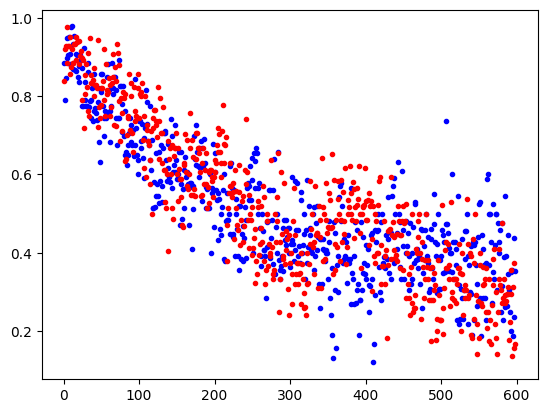

In [18]:
plt.plot(group_averages['time']['CS1']['p_plus_plus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['CS2']['p_plus_plus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

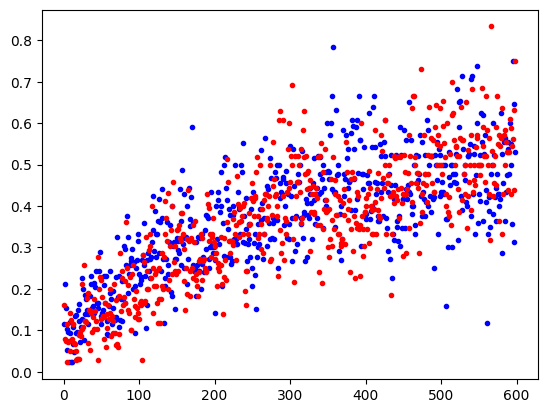

In [19]:
plt.plot(group_averages['time']['CS1']['p_plus_minus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['CS2']['p_plus_minus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

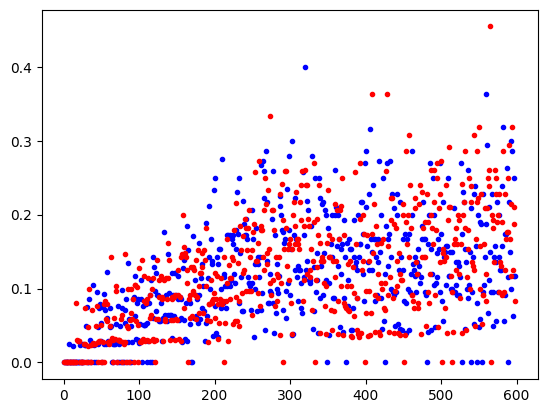

In [20]:
plt.plot(group_averages['time']['CS1']['p_plus_zero_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['CS2']['p_plus_zero_given_plus'].iloc[0][2:602], 'r.')
plt.show()

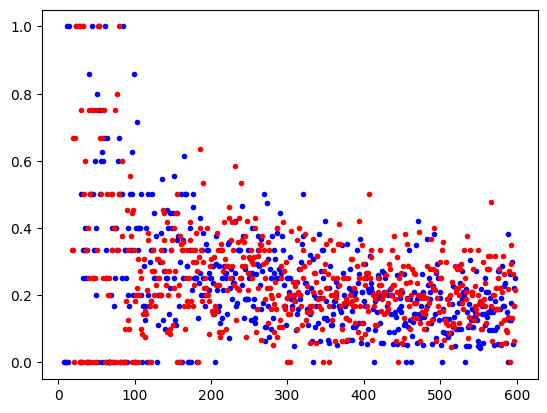

In [21]:
plt.plot(group_averages['time']['CS1']['p_zero_plus_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['CS2']['p_zero_plus_given_zero'].iloc[0][2:602], 'r.')
plt.show()

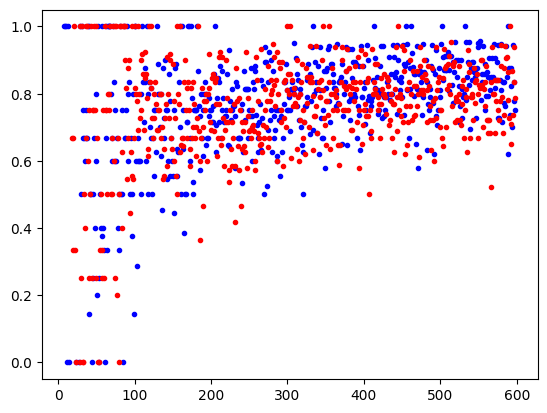

In [22]:
plt.plot(group_averages['time']['CS1']['p_zero_zero_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['CS2']['p_zero_zero_given_zero'].iloc[0][2:602], 'r.')
plt.show()

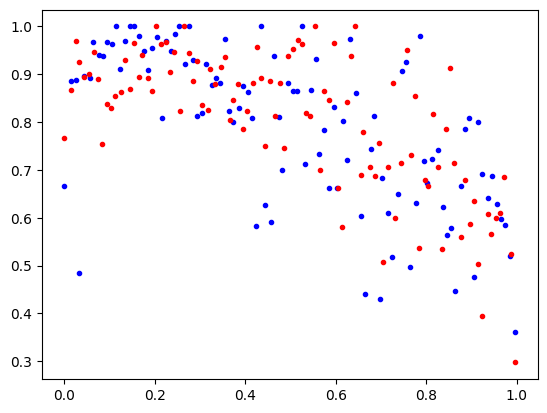

In [23]:
plt.plot(group_averages['percent_coverage']['CS1']['percent_coverage mean'],
         group_averages['percent_coverage']['CS1']['p_plus_plus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['CS2']['percent_coverage mean'],
         group_averages['percent_coverage']['CS2']['p_plus_plus_given_plus mean'], 'r.')
plt.show()

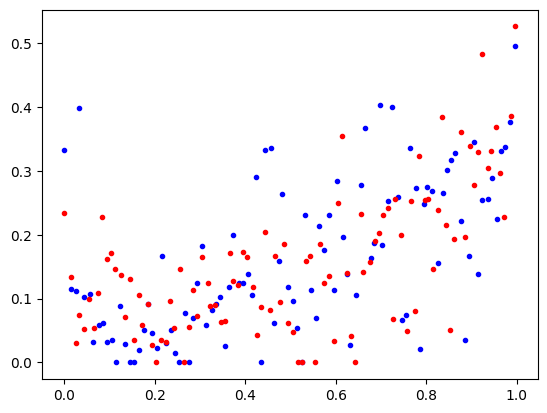

In [24]:
plt.plot(group_averages['percent_coverage']['CS1']['percent_coverage mean'],
         group_averages['percent_coverage']['CS1']['p_plus_minus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['CS2']['percent_coverage mean'],
         group_averages['percent_coverage']['CS2']['p_plus_minus_given_plus mean'], 'r.')
plt.show()

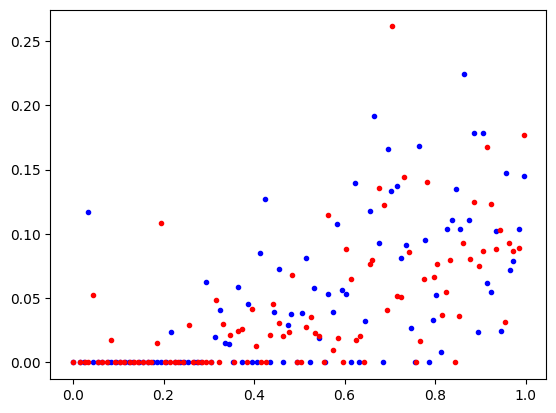

In [25]:
plt.plot(group_averages['percent_coverage']['CS1']['percent_coverage mean'],
         group_averages['percent_coverage']['CS1']['p_plus_zero_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['CS2']['percent_coverage mean'],
         group_averages['percent_coverage']['CS2']['p_plus_zero_given_plus mean'], 'r.')
plt.show()

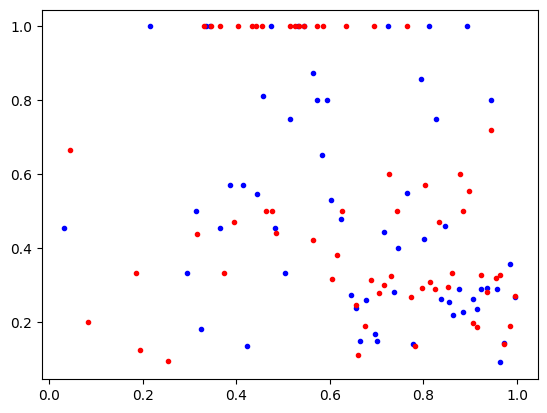

In [26]:
plt.plot(group_averages['percent_coverage']['CS1']['percent_coverage mean'],
         group_averages['percent_coverage']['CS1']['p_zero_plus_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['CS2']['percent_coverage mean'],
         group_averages['percent_coverage']['CS2']['p_zero_plus_given_zero mean'], 'r.')
plt.show()

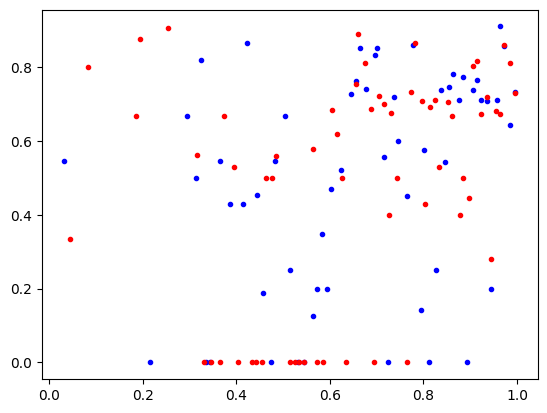

In [27]:
plt.plot(group_averages['percent_coverage']['CS1']['percent_coverage mean'],
         group_averages['percent_coverage']['CS1']['p_zero_zero_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['CS2']['percent_coverage mean'],
         group_averages['percent_coverage']['CS2']['p_zero_zero_given_zero mean'], 'r.')
plt.show()

## 5. Fit models to individuals' measures

### 5a. Naive bounds
We will first fit models with naive bounds. This means the bounds are set only so that they ensure the parameters have the correct sign. Some individuals may result in parameters that are very unlike the majority of individuals' parameters in some models.

The ``fit_all`` function will fit time vs y-measure models for all y-measures defined in the ``time_averaged_measures`` attribute of your ``Defaults`` instance. It will also fit coverage-measure vs y-measure models for all y-measures defined in the ``coverage_averaged_measures`` attribute of your ``Defaults`` instance, for each coverage-measure (coverage, pica, pgca, and percent_coverage). You must have a ``ModelSpecification`` instance for each of these models. If you used the ``set_up_fits`` function, you should be set. If not, you will need to make sure that you have either created a ``ModelSpecification`` for each model listed, or that you have provided a custom argument to ``time_averaged_measures`` and/or ``coverage_averaged_measures``.

The ``fit_all`` function will return nested dictionaries, the first keyed by group name, then by x-axis, then by y-axis which will ultimately return a dataframe containing the parameters fit on each individual in that group for that x vs y model.

In [28]:
naive_fits = fit_all(individual_measures_dfs=individual_dfs,
                     defaults=default_settings,
                     model_params=model_settings)

Fitting Models To Tracks From Group CS1 by time
Fitting Models To Tracks From Group CS1 by coverage
Fitting Models To Tracks From Group CS1 by pica
Fitting Models To Tracks From Group CS1 by pgca
Fitting Models To Tracks From Group CS1 by percent_coverage
Fitting Models To Tracks From Group CS2 by time
Fitting Models To Tracks From Group CS2 by coverage
Fitting Models To Tracks From Group CS2 by pica
Fitting Models To Tracks From Group CS2 by pgca
Fitting Models To Tracks From Group CS2 by percent_coverage


### 5b. Find new bounds
Now that we have fit the models with naive bounds, we want to take care of any outliers. Because there are so many models, we want to preserve the use of all of our data. Additionally, if an individual is an outlier in terms of one parameter, it would be difficult to decide whether we need to throw out that just that parameter, all the parameters of that model (which of course, are not independent) for that individual, or all the parameters of all the models for that individual.

In order to preserve our data, we will instead calculate new bounds and ultimately re-fit all the models with these bounds that ensure we do not get outliers.

The ``find_fit_bounds`` function does this by looking at the distribution of the naive fit parameters for each group separately. It finds the mean and standard deviation of each distribution, and then sets the upper and lower bounds for the re-fit to 2 standard deviations above and below the mean (95% of data should fall here, thus we are unlikely to influence many non-outlier individuals). The number of standard deviations to use for the cutoff can be set in the ``UserInput`` instance, using the optional ``bound_level`` attribute. It will also set the new initial parameter guess to the distribution mean, to ensure that our p0 is within the bounds.

The three returns are all nested dictionaries, first keyed by group, then x-axis, then y-axis. This results in a dataframe of the upper bounds, lower_bounds, or initial parameter values for all each of the parameters in the model.

In [29]:
upper_bounds, lower_bounds, p0s = find_fit_bounds(fits=naive_fits,
                                                  user_inputs=user_settings)

### 5c. Re-fit models
Now that we have more precise bounds, we need to re-fit the models. The ``re_fit_all`` function will fit all the same models that ``fit_all`` did, but using the new bounds we calculated in ``find_fit_bounds``.

It will return nested dictionaries, the first keyed by group name, then by x-axis, then by y-axis which will ultimately return a dataframe containing the (outlier-free) parameters fit on each individual in that group for that x vs y model.

In [30]:
bounded_fits = re_fit_all(individual_measures_dfs=individual_dfs,
                          defaults=default_settings,
                          model_params=model_settings,
                          upper=upper_bounds,
                          lower=lower_bounds,
                          initial=p0s)

Re-Fitting Models To Tracks From Group CS1 by time
Re-Fitting Models To Tracks From Group CS1 by coverage
Re-Fitting Models To Tracks From Group CS1 by pica
Re-Fitting Models To Tracks From Group CS1 by pgca
Re-Fitting Models To Tracks From Group CS1 by percent_coverage
Re-Fitting Models To Tracks From Group CS2 by time
Re-Fitting Models To Tracks From Group CS2 by coverage
Re-Fitting Models To Tracks From Group CS2 by pica
Re-Fitting Models To Tracks From Group CS2 by pgca
Re-Fitting Models To Tracks From Group CS2 by percent_coverage


### 5d. Format and save the bounded individual fits
Next we can use ``format_params`` to create dataframes from the nested dictionaries created in ``re_fit_all``. This will also save out a .csv file for each group that contains all parameter fits for all individuals in that group. They will be found under 'ExpectedResults/Individuals/CantonS_1/Models' for CS1, under 'ExpectedResults/Individuals/CantonS_2/Models' for CS2, and under 'ExpectedResults/Individuals/CombinedGroups/Models' for both CS1 and CS2 combined.

If you do not want to save the .csv files you can make sure the ``save_group_model_csvs`` and ``save_all_group_model_csvs`` attributes of your ``Defaults`` instance are set to False in step 2c.

In [31]:
formatted_bounded_fits = format_params(bounded_fits=deepcopy(bounded_fits),
                                       defaults=default_settings,
                                       user_inputs=user_settings)

## 6. Fit models to group measures

### 6a. Fit the group models with bounds
We also want to fit a model to the entire group's data. The ``group_fit_all`` function will fit all the same models as the ``fit_all`` and ``re_fit_all`` functions did, but using the data from all individuals in a group. We will use the bounds and p0s that we calculated using the ``find_fit_bounds``.

It returns a nested dictionary, first keyed by group, then by x-measure, then by y-measure. This will yield a dataframe with the all the fit parameters for that model.

In [32]:
group_fits = group_fit_all(individual_measures_dfs=individual_dfs,
                           defaults=default_settings,
                           model_params=model_settings,
                           upper=upper_bounds,
                           lower=lower_bounds,
                           initial=p0s)

Fitting Models To Entire Group CS1 by time
Fitting Models To Entire Group CS1 by coverage
Fitting Models To Entire Group CS1 by pica
Fitting Models To Entire Group CS1 by pgca
Fitting Models To Entire Group CS1 by percent_coverage
Fitting Models To Entire Group CS2 by time
Fitting Models To Entire Group CS2 by coverage
Fitting Models To Entire Group CS2 by pica
Fitting Models To Entire Group CS2 by pgca
Fitting Models To Entire Group CS2 by percent_coverage


### 6b. Format and save the bounded group fits
Next we can use ``format_group_params`` to create dataframes from the nested dictionaries created in ``group_fit_all``. This will save out a .csv file for each group that contains the parameter fits for that group. They will be found under 'ExpectedResults/Groups/CantonS_1/Models' for CS1, under 'ExpectedResults/Groups/CantonS_2/Models' for CS2, and under 'ExpectedResults/Groups/CombinedGroups/Models' for both CS1 and CS2 combined.

If you do not want to save the .csv files you can make sure the ``save_group_model_csvs`` and ``save_all_group_model_csvs`` attributes of your ``Defaults`` instance are set to False in step 2c. Or, you could skip running this cell.

In [33]:
format_group_params(group_fits=deepcopy(group_fits),
                    defaults=default_settings,
                    user_inputs=user_settings)

## 7. Run statistical tests
Now, using the formatted parameter fits from the individuals, we can perform MANOVA, ANOVA, and T-tests on the parameters to identify differences between groups. The ``run_tests`` function will orchestrate all of these tests. The results can be found in a text file under 'ExpectedResults/Stats'. 

In [34]:
run_tests(formatted_bounded_fits=formatted_bounded_fits,
          defaults=default_settings,
          user_inputs=user_settings)

## 8. Plot the results

### 8a. Plot individuals
The ``plot_all_individuals`` function will coordinate plotting every relationship modeled in steps 5-6, for every individual in every group.

It can display the figures and/or save them. If they are saved, you can find them under 'ExpectedResults/Individuals/CantonS_1/Plots/' for CS1, and under 'ExpectedResults/Individuals/CantonS_2/Plots/' for CS2. They are further divided by which measure is used as the x-axis (time, coverage, pica, pgca, or percent_coverage). You can customize the plot colors and the model display by changing the appropriate settings in your ``PlotSettings`` instance.

A performance note: this function can be slow, especially if we have ``display_individual_figures`` set to True in our ``PlotSettings`` instance.

In [35]:
plot_all_individuals(measures=individual_dfs,
                     model_params=bounded_fits,
                     model_info=model_settings,
                     defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Individuals From Group CS1 by time
Plotting Individuals From Group CS1 by coverage
Plotting Individuals From Group CS1 by pica
Plotting Individuals From Group CS1 by pgca
Plotting Individuals From Group CS1 by percent_coverage
Plotting Individuals From Group CS2 by time
Plotting Individuals From Group CS2 by coverage
Plotting Individuals From Group CS2 by pica
Plotting Individuals From Group CS2 by pgca
Plotting Individuals From Group CS2 by percent_coverage


### 8b. Plot traces
The ``plot_traces`` function will coordinate plotting the track trajectory, for every individual in every group.

It can display the figures and/or save them. If they are saved, you can find them under 'ExpectedResults/Individuals/CantonS_1/Plots/traces' for CS1, and under 'ExpectedResults/Individuals/CantonS_2/Plots/traces' for CS2. You can customize color bar by changing the appropriate setting in your ``PlotSettings`` instance.

In [36]:
plot_traces(tracks_by_groups=tracks_by_groups,
            plot_settings=plot_settings,
            user_input=user_settings)

### 8c. Plot group averages
The ``plot_all_solo_groups`` function will coordinate plotting every relationship modeled in steps 5-6, for each group's average values.

It can display the figures and/or save them. If they are saved, you can find them under 'ExpectedResults/Groups/CantonS_1/Plots/' for CS1, and under 'ExpectedResults/Groups/CantonS_2/Plots/' for CS2. They are further divided by which measure is used as the x-axis (time, coverage, pica, pgca, or percent_coverage). You can customize the plot colors and the model and error display by changing the appropriate settings in your ``PlotSettings`` instance.

In [37]:
plot_all_solo_groups(group_averages=group_averages,
                     group_fits=group_fits,
                     model_params=model_settings,
                     test_defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Group CS1 by time
Plotting Group CS1 by coverage
Plotting Group CS1 by pica
Plotting Group CS1 by pgca
Plotting Group CS1 by percent_coverage
Plotting Group CS2 by time
Plotting Group CS2 by coverage
Plotting Group CS2 by pica
Plotting Group CS2 by pgca
Plotting Group CS2 by percent_coverage


### 8d. Plot group averages with component individuals
The ``plot_components_of_solo_groups`` function will coordinate plotting every relationship modeled in steps 5-6, for each group's average values. On the same plot as these average values, the data from the individuals that make up that group are also displayed, so that you can see how the averages reflect the individuals. This format may be useful in deciding what an appropriate value for the `n_points_coverage`, `n_points_pica`, `n_points_pgca`, or `n_bins_percent_coverage` attribute of your `Defaults` instance is.

It can display the figures and/or save them. If they are saved, you can find them under 'ExpectedResults/Groups/CantonS_1/Plots/' for CS1, and under 'ExpectedResults/Groups/CantonS_2/Plots/' for CS2. They are further divided by which measure is used as the x-axis (time, coverage, pica, pgca, or percent_coverage) and include 'individual_view' in the folder name. You can customize the plot colors and the model and error display by changing the appropriate settings in your ``PlotSettings`` instance.

In [38]:
plot_components_of_solo_groups(individuals=individual_dfs,
                               individual_fits=bounded_fits,
                               groups=group_averages,
                               group_fits=group_fits,
                               model_specs=model_settings,
                               defaults=default_settings,
                               plot_settings=plot_settings,
                               user_inputs=user_settings)

Plotting Group And Individuals of CS1 by time
Plotting Group And Individuals of CS1 by coverage
Plotting Group And Individuals of CS1 by pica
Plotting Group And Individuals of CS1 by pgca
Plotting Group And Individuals of CS1 by percent_coverage
Plotting Group And Individuals of CS2 by time
Plotting Group And Individuals of CS2 by coverage
Plotting Group And Individuals of CS2 by pica
Plotting Group And Individuals of CS2 by pgca
Plotting Group And Individuals of CS2 by percent_coverage


### 8e. Plot group average comparisons
The ``plot_all_group_comparisons`` function will coordinate plotting every relationship modeled in steps 5-6, with all group averages displayed on the same plot. This is where you can see the differences between groups that were identified in the statistical tests, reflected visually.

It can display the figures and/or save them. If they are saved, you can find them under 'ExpectedResults/GroupsComparisonPlots'. They are further divided by which measure is used as the x-axis (time, coverage, pica, pgca, or percent_coverage). You can customize the plot colors and the model and error display by changing the appropriate settings in your ``PlotSettings`` instance.

In [39]:
plot_all_group_comparisons(group_averages=group_averages,
                           group_fits=group_fits,
                           model_params=model_settings,
                           test_defaults=default_settings,
                           plot_settings=plot_settings,
                           user_config=user_settings)

Plotting Group Comparisons by time
Plotting Group Comparisons by coverage
Plotting Group Comparisons by pica
Plotting Group Comparisons by pgca
Plotting Group Comparisons by percent_coverage


## 9. Summarize the run
Now that we've finished, we want to save all the settings we used so that we can replicate the results later, or compare results from using different settings. Running the ``summary_file`` function will create a text file under the main 'ExpectedResults' folder that lists the number of individuals in each group, and the settings from each of the dataclasses we set up throughout step 2.

In [40]:
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings)

Formatting Summary File


## You're done!
Now that you have a hang of the analysis, try it out with own data! If you run into any issues, check out the rest of the documentation, or feel free to contact me with any bug reports or feature requests.

Ellen McMullen